## O Cenário #

Imagine uma grande fazenda moderna que dividiu suas terras em 200 talhões (lotes de terra). Para cada talhão, a fazenda quer monitorar a saúde do solo, que pode ser Rica, Moderada ou Pobre em nutrientes. Medir diretamente a saúde do solo (com análises químicas) é caro e lento.

No entanto, toda semana, um drone sobrevoa a fazenda e tira fotos, classificando o aspecto da cultura (a plantação) em cada talhão como Vigoroso, Amarelado ou Murcho. Esta é uma observação barata e rápida.

O estado oculto (Saúde do Solo) influencia diretamente o que observamos (Aspecto da Cultura). Além disso, a saúde do solo de uma semana influencia a da semana seguinte (um solo pobre tende a continuar pobre).

### O Objetivo do Exercício: ### 
Construir uma DBN que use o histórico semanal do aspecto visual da cultura (nossa observação) para inferir a saúde real do solo (o estado oculto), permitindo que o agricultor tome decisões informadas sobre onde e quando aplicar fertilizantes.

In [21]:
#install pip install pgmpy

## Importando as bibliotecas necessarias ##

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import DynamicBayesianNetwork
from pgmpy.inference import DBNInference
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Carregar e Mapear os dados ##

In [23]:
df_completo = pd.read_csv('saude_solo_fazenda_GRANDE.csv')

map_solo = {0: 'Rico', 1: 'Moderado', 2: 'Pobre'}
map_cultura = {0: 'Vigorosa', 1: 'Amarelada', 2: 'Murcha'}

## Dividindo talhões em treino e teste ##

In [24]:
ids_dos_talhoes = df_completo['talhao_id'].unique()
ids_treino, ids_teste = train_test_split(ids_dos_talhoes, test_size=0.25, random_state=42)
df_treino = df_completo[df_completo['talhao_id'].isin(ids_treino)]
df_teste = df_completo[df_completo['talhao_id'].isin(ids_teste)]
print(f"Talhões para treino: {len(ids_treino)}. Talhões para teste: {len(ids_teste)}.")

Talhões para treino: 1500. Talhões para teste: 500.


Pense nesta função como um preparador de "fotos de antes e depois". O modelo DBN não aprende olhando para uma semana de cada vez; ele precisa ver o "antes" (tempo t) e o "depois" (tempo t+1) lado a lado para entender como as coisas mudam.

    Linhas 2-3: Primeiro, selecionamos as colunas que nos interessam e as renomeamos para o formato (Variavel, 0), que para a DBN significa "no tempo t" (o "antes").

    Linhas 4-5: Aqui está a mágica. O comando .shift(-1) "puxa para cima" toda a coluna em uma posição. Isso coloca o valor da semana seguinte na mesma linha da semana atual, criando as colunas do "depois" ((Variavel, 1)).

    Linha 6: A última linha do dataframe agora terá valores vazios (NaN) nas colunas do "depois", pois não há uma semana seguinte para "puxar". O .dropna() simplesmente remove essa linha inútil.

## Preparar os dados de treino para a DBN ##

In [25]:
def preparar_fatia_temporal(df_talhao):
    df_talhao = df_talhao[['saude_solo_int', 'aspecto_cultura_int']].copy()
    df_talhao.columns = [('Solo', 0), ('Cultura', 0)]
    df_talhao[('Solo', 1)] = df_talhao[('Solo', 0)].shift(-1)
    df_talhao[('Cultura', 1)] = df_talhao[('Cultura', 0)].shift(-1)
    return df_talhao.dropna()

In [26]:
dados_para_treino = df_treino.groupby('talhao_id').apply(preparar_fatia_temporal).reset_index(drop=True)
for col in dados_para_treino.columns:
    dados_para_treino[col] = dados_para_treino[col].astype(int)

C:\Users\danig\AppData\Local\Temp\ipykernel_23040\2552168561.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_para_treino = df_treino.groupby('talhao_id').apply(preparar_fatia_temporal).reset_index(drop=True)


## Definir e treinar o modelo ##

"Antes de escrever qualquer código, vamos pensar no nosso problema da fazenda como se estivéssemos desenhando um diagrama no quadro. Nós temos duas ideias principais, ou 'leis da natureza', que queremos que nosso modelo entenda."

Passo 1: As Duas "Leis" do Nosso Universo (O Desenho no Quadro)

"No nosso cenário da fazenda, temos duas regras fundamentais:"

1. A Lei da Transição (Como o mundo evolui com o tempo):

    "A saúde do solo em uma semana influencia diretamente a saúde do solo na semana seguinte."

    Um solo que é Pobre hoje tem uma alta chance de continuar Pobre na semana que vem.

    Visualmente, desenhamos isso como uma seta que cruza o tempo:

    Saúde do Solo (hoje) ------------> Saúde do Solo (amanhã)

2. A Lei da Emissão (Como o estado oculto causa o que vemos):

    "A saúde do solo em uma determinada semana influencia diretamente a aparência da plantação naquela mesma semana."

    Um solo Rico "emite" o sinal de uma cultura Vigorosa.

    Visualmente, é uma seta que aponta do estado oculto para a observação, dentro do mesmo instante de tempo:

    Saúde do Solo (hoje) ----> Aspecto da Cultura (hoje)

"Se combinarmos isso, nosso 'desenho' para dois momentos no tempo (hoje e amanhã, ou t e t+1) fica assim:"

      [Solo (t)] --------> [Solo (t+1)]
          |                      |
          |                      |
          v                      v
      [Cultura (t)]          [Cultura (t+1)]

"Este diagrama é a estrutura do nosso modelo. É a nossa hipótese sobre como as variáveis se relacionam. Agora, como traduzimos este desenho para o código Python?"

Passo 2: A Sintaxe do pgmpy - Entendendo os Nós

"A biblioteca pgmpy representa cada caixa (ou 'nó') do nosso diagrama com uma tupla de dois elementos: ('NomeDaVariavel', fatia_de_tempo)."

    ('Solo', 0) representa a caixa "Solo no tempo t" (o "hoje").

    ('Solo', 1) representa a caixa "Solo no tempo t+1" (o "amanhã").

    ('Cultura', 0) representa a caixa "Cultura no tempo t".

    ('Cultura', 1) representa a caixa "Cultura no tempo t+1".

"O 0 e o 1 não são tempos absolutos, são apenas rótulos para a fatia 'antes' e 'depois' no nosso diagrama."

Passo 3: Traduzindo as "Leis" para "Arestas" de Código

"Agora, vamos traduzir cada seta do nosso desenho para uma 'aresta' de código. Uma aresta é simplesmente uma tupla contendo o nó de origem e o nó de destino."

    Lei da Transição:

        A seta [Solo (t)] ---> [Solo (t+1)]

        Se traduz para a tupla: ( ('Solo', 0), ('Solo', 1) )

    Lei da Emissão no tempo t:

        A seta [Solo (t)] ---> [Cultura (t)]

        Se traduz para a tupla: ( ('Solo', 0), ('Cultura', 0) )

    Lei da Emissão no tempo t+1:

        A seta [Solo (t+1)] ---> [Cultura (t+1)]

        Se traduz para a tupla: ( ('Solo', 1), ('Cultura', 1) )

In [ ]:
dbn_model = DynamicBayesianNetwork()
dbn_model.add_edges_from([
    (('Solo', 0), ('Cultura', 0)),
    (('Solo', 0), ('Solo', 1)),
    (('Solo', 1), ('Cultura', 1)),
])

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Solo_0': 'N', 'Cultura_0': 'N', 'Solo_1': 'N', 'Cultura_1': 'N'}


Modelo treinado com sucesso.


Se a DBNInference é a "prova final", o .fit() é o "período de estudo intensivo".

    dbn_model: É o nosso "aluno". Ele já tem a estrutura do conhecimento (as arestas que definimos), mas suas tabelas de probabilidade estão vazias. Ele ainda não sabe nada.

    .fit(): É o comando que diz: "estude!".

    dados_para_treino: É todo o material de estudo. É aquele DataFrame especial que preparamos com a função preparar_fatia_temporal, cheio de exemplos de "antes e depois".

    estimator="MLE": É o método de estudo. "MLE" significa Maximum Likelihood Estimator (Estimador de Máxima Verossimilhança). De forma simples, o método MLE funciona contando as frequências no material de estudo. Para aprender a probabilidade de um solo Pobre continuar Pobre, ele conta: "De todas as vezes que o solo era Pobre no tempo t, em qual porcentagem de vezes ele também era Pobre no tempo t+1?". Ele faz isso para todas as combinações possíveis, preenchendo suas tabelas de probabilidade com as estatísticas que melhor explicam os dados que ele viu.

In [ ]:
dbn_model.fit(dados_para_treino, estimator="MLE")
print("Modelo treinado com sucesso.")

Este bloco de código é a "prova final" do nosso modelo. Nós passamos por cada talhão que o modelo nunca viu antes (o conjunto de teste) e fazemos o seguinte:

    Isolamos um Aluno: Pegamos os dados de um único talhao_id para testar.

    Preparamos a Prova: Criamos o evidencia_dict. Isso é como entregar a prova para o modelo, mas apenas com as perguntas (as observacoes que vimos, como o aspecto da cultura), escondendo as respostas (o saude_solo_int real).

    O Modelo "Pensa": A linha dbn_inference.query(...) é o momento em que o modelo usa todo o seu conhecimento para "preencher as lacunas". Ele olha para a sequência de observações e infere qual é a sequência de estados ocultos mais provável que poderia ter gerado o que ele viu.

    Extraímos a Resposta: O resultado do .query() é uma probabilidade para cada estado em cada semana. A linha solo_inferido = [np.argmax(fator.values)...] simplesmente escolhe o estado com a maior probabilidade em cada semana para ser a resposta final do modelo.

    Guardamos Tudo: Ao final, adicionamos as respostas do modelo (lista_inferidos) e as respostas corretas (lista_reais) a uma lista geral. Depois que o loop terminar, usaremos essas listas para dar a "nota final" do modelo (o relatório de classificação).

## Avaliação no conjunto de teste ##

In [28]:
lista_reais = []
lista_inferidos = []
dbn_inference = DBNInference(dbn_model)

for talhao_id in ids_teste:
    df_talhao_teste = df_teste[df_teste['talhao_id'] == talhao_id]
    observacoes = df_talhao_teste['aspecto_cultura_int'].tolist()
    n_semanas = len(observacoes)
    evidencia_dict = {('Cultura', t): observacoes[t] for t in range(n_semanas)}
    variaveis_query = [('Solo', t) for t in range(n_semanas)]
    
    resultado_inferencia = dbn_inference.query(variables=variaveis_query, evidence=evidencia_dict)
    fatores = [f for t, f in sorted(resultado_inferencia.items())]
    solo_inferido = [np.argmax(fator.values) for fator in fatores]
    
    lista_inferidos.extend(solo_inferido)
    lista_reais.extend(df_talhao_teste['saude_solo_int'].tolist())

## Análise dos resultados de teste ##


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

        Rico       0.89      0.76      0.82     15687
    Moderado       0.46      0.43      0.44      7430
       Pobre       0.38      0.75      0.50      2883

    accuracy                           0.66     26000
   macro avg       0.57      0.64      0.59     26000
weighted avg       0.71      0.66      0.67     26000

Matriz de Confusão:


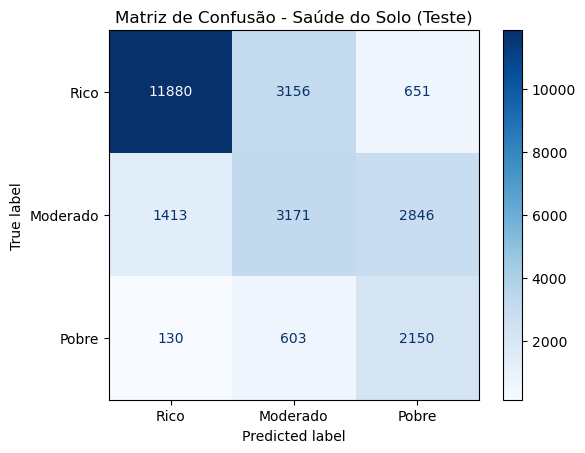

In [ ]:
nomes_das_classes = list(map_solo.values())

print("\nRelatório de Classificação Detalhado:")
print(classification_report(lista_reais, lista_inferidos, target_names=nomes_das_classes))

print("Matriz de Confusão:")
cm = confusion_matrix(lista_reais, lista_inferidos)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_das_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Saúde do Solo (Teste)")
plt.show()

## O Impacto da Escala - Aumentando a Quantidade de Dados

### O Objetivo: 
Vamos repetir nosso exercício da "Fazenda Inteligente", mas em vez de simular 200 talhões, vamos simular 2000 talhões (10 vezes mais dados), mantendo os 52 meses de histórico. Isso nos dará um total de mais de 100.000 registros.

### A Hipótese: 
Nossa expectativa é que, com um volume de dados muito maior, o modelo será capaz de aprender as nuances e as fronteiras entre as classes (especialmente a difícil classe Moderado) com muito mais precisão.

Só precisamos trocar o csv de saude_solo_fazenda.csv para saude_solo_fazenda_GRANDE.csv

Análise dos Resultados da Fase 2

Agora, vamos comparar o novo relatório com o da Fase 1, que vimos no início.

(Aqui você mostra os dois relatórios lado a lado e guia a discussão)

Perguntas a serem respondidas:

    A acurácia geral aumentou como esperávamos?

    O que aconteceu com a precisão e o recall da nossa classe mais fraca, a Moderado?

    Vemos alguma mudança significativa na performance da classe Pobre?

Como podemos ver, os resultados quase não mudaram! Aumentar os dados em 10 vezes não resolveu o problema fundamental. Isso nos ensina uma lição crucial sobre o 'platô de performance' e nos prepara perfeitamente para a Fase 3, onde vamos atacar o problema de outra forma: enriquecendo a qualidade dos nossos dados, e não apenas a quantidade.

## Aumentando a Riqueza dos Dados (Múltiplas Observações)

## O Cenário: 
Continuamos na nossa fazenda de 200 talhões. Mas agora, nosso drone não é apenas uma câmera. Ele foi equipado com novos sensores e agora nos dá três observações toda semana:

    aspecto_cultura_int (a que já tínhamos).

    umidade_solo_obs_int: Um sensor de umidade (0: Seco, 1: Úmido, 2: Encharcado).

    pragas_obs_int: Um sistema de visão que detecta a presença de pragas (0: Nenhuma, 1: Poucas, 2: Muitas).

## A Hipótese: 
Com três fontes de evidência em vez de uma, o modelo terá muito mais facilidade em distinguir os estados de risco, especialmente a classe Moderado.

### Principais mudanças feitas na parte 3 em comparação com a parte 1:
1. A Estrutura da Rede (add_edges_from):
Nossa "planta baixa" agora é mais complexa. O estado Solo influencia três observações, não apenas uma.
2. A Preparação dos Dados:
Nossa função preparar_fatia_temporal_multi agora precisa selecionar e processar as novas colunas de dados (umidade_solo_int, pragas_int).
3. A Evidência para Inferência:
Quando formos testar o modelo, o evidencia_dict será muito mais rico. Em vez de darmos apenas uma informação por semana, agora forneceremos três. É como um médico que, em vez de ter apenas a aparência do paciente, agora tem também a temperatura e a pressão arterial para fazer seu diagnóstico.

In [33]:
df_completo = pd.read_csv('saude_solo_fazenda_MULTIVARIADO.csv')

map_solo = {0: 'Rico', 1: 'Moderado', 2: 'Pobre'}

In [34]:
ids_dos_talhoes = df_completo['talhao_id'].unique()
ids_treino, ids_teste = train_test_split(ids_dos_talhoes, test_size=0.25, random_state=42)
df_treino = df_completo[df_completo['talhao_id'].isin(ids_treino)]
df_teste = df_completo[df_completo['talhao_id'].isin(ids_teste)]
print(f"Talhões para treino: {len(ids_treino)}. Talhões para teste: {len(ids_teste)}.")

Talhões para treino: 150. Talhões para teste: 50.


## Adaptar dados do treino ##

In [35]:
def preparar_fatia_temporal_multi(df_talhao):
    # Selecionamos todas as colunas relevantes
    cols_t0 = ['saude_solo_int', 'aspecto_cultura_int', 'umidade_solo_int', 'pragas_int']
    df_t0 = df_talhao[cols_t0].copy()
    # Renomeamos com a tupla (variável, tempo)
    df_t0.columns = [('Solo', 0), ('Cultura', 0), ('Umidade', 0), ('Pragas', 0)]
    
    # Criamos as colunas para o tempo t+1
    for col_name, time_slice in df_t0.columns:
        df_t0[(col_name, 1)] = df_t0[(col_name, 0)].shift(-1)
        
    return df_t0.dropna()

dados_para_treino = df_treino.groupby('talhao_id').apply(preparar_fatia_temporal_multi).reset_index(drop=True)
for col in dados_para_treino.columns:
    dados_para_treino[col] = dados_para_treino[col].astype(int)

C:\Users\danig\AppData\Local\Temp\ipykernel_23040\1028041590.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_para_treino = df_treino.groupby('talhao_id').apply(preparar_fatia_temporal_multi).reset_index(drop=True)


 [Solo (t)] -------------------------------------> [Solo (t+1)]
          |                                                  |
    +-----+----------------+                         +-------+----------------+
    |     |                |                         |       |                |
    v     v                v                         v       v                v
[Cultura (t)] [Umidade (t)] [Pragas (t)]        [Cultura (t+1)] [Umidade (t+1)] [Pragas (t+1)]

## Adaptar definir e treinar modelo ##

In [36]:
dbn_model_multi = DynamicBayesianNetwork()
# A ESTRUTURA DA REDE AGORA É MAIS RICA
dbn_model_multi.add_edges_from([
    # Dependências no tempo t=0
    (('Solo', 0), ('Cultura', 0)),
    (('Solo', 0), ('Umidade', 0)),
    (('Solo', 0), ('Pragas', 0)),
    # Dependência temporal
    (('Solo', 0), ('Solo', 1)),
    # Dependências no tempo t=1
    (('Solo', 1), ('Cultura', 1)),
    (('Solo', 1), ('Umidade', 1)),
    (('Solo', 1), ('Pragas', 1)),
])
dbn_model_multi.fit(dados_para_treino, estimator="MLE")
print("Modelo treinado com sucesso.")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Solo_0': 'N', 'Cultura_0': 'N', 'Umidade_0': 'N', 'Pragas_0': 'N', 'Solo_1': 'N', 'Cultura_1': 'N', 'Umidade_1': 'N', 'Pragas_1': 'N'}


Modelo treinado com sucesso.


## Adaptar avaliação no conjuto de teste ##

In [37]:
lista_reais = []
lista_inferidos = []
dbn_inference = DBNInference(dbn_model_multi)

for talhao_id in ids_teste:
    df_talhao_teste = df_teste[df_teste['talhao_id'] == talhao_id]
    n_semanas = len(df_talhao_teste)
    
    # A EVIDÊNCIA AGORA É MUITO MAIS RICA
    evidencia_dict = {}
    for t in range(n_semanas):
        evidencia_dict[('Cultura', t)] = df_talhao_teste['aspecto_cultura_int'].iloc[t]
        evidencia_dict[('Umidade', t)] = df_talhao_teste['umidade_solo_int'].iloc[t]
        evidencia_dict[('Pragas', t)] = df_talhao_teste['pragas_int'].iloc[t]

    variaveis_query = [('Solo', t) for t in range(n_semanas)]
    resultado_inferencia = dbn_inference.query(variables=variaveis_query, evidence=evidencia_dict)
    
    fatores = [f for t, f in sorted(resultado_inferencia.items())]
    solo_inferido = [np.argmax(fator.values) for fator in fatores]
    
    lista_inferidos.extend(solo_inferido)
    lista_reais.extend(df_talhao_teste['saude_solo_int'].tolist())


--- ANÁLISE DA PERFORMANCE (MODELO MULTIVARIADO) ---
              precision    recall  f1-score   support

        Rico       0.89      0.87      0.88      1625
    Moderado       0.61      0.59      0.60       727
       Pobre       0.51      0.64      0.57       248

    accuracy                           0.77      2600
   macro avg       0.67      0.70      0.68      2600
weighted avg       0.78      0.77      0.77      2600



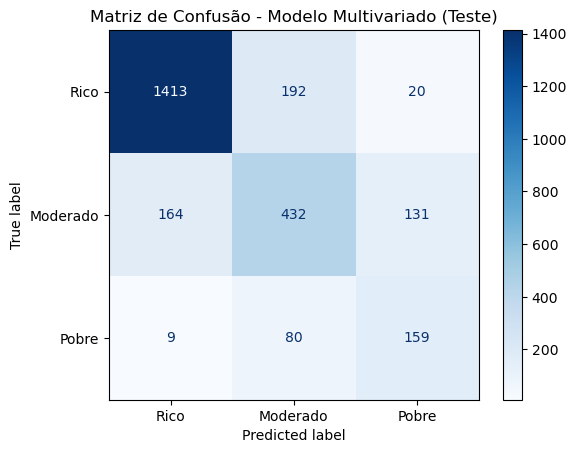

In [38]:
print("\n--- ANÁLISE DA PERFORMANCE (MODELO MULTIVARIADO) ---")
nomes_das_classes = list(map_solo.values())
print(classification_report(lista_reais, lista_inferidos, target_names=nomes_das_classes))
cm = confusion_matrix(lista_reais, lista_inferidos)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_das_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Modelo Multivariado (Teste)")
plt.show()

Perguntas finais a serem respondidas:

    Qual foi o impacto na acurácia geral?

    O que aconteceu com a nossa classe mais fraca, a Moderado? (A precisão e o recall devem ter melhorado drasticamente).

    Vejam o trade-off na classe Pobre: a precisão aumentou muito. O que isso significa para o agricultor na prática? (Menos "alarmes falsos", ou seja, menos desperdício de fertilizante).

A lição final e mais importante da nossa jornada hoje é: Engenharia de Features. A forma mais poderosa de melhorar um modelo preditivo, muitas vezes, não é usar algoritmos mais complexos ou ter mais do mesmo dado, mas sim enriquecer o modelo com novas fontes de informação de qualidade.